# Imports & loading

In [1]:
from support import load_dataset
import matplotlib.pyplot as plt
import torchvision.transforms as T
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
from tqdm.notebook import tqdm 

import pandas as pd

import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

import optuna
from optuna.visualization import (
    plot_optimization_history,
    plot_param_importances,
    plot_parallel_coordinate,
    plot_slice,
    plot_contour,
)
import plotly

In [2]:
import torch, gc, os

def get_device():
    if torch.backends.mps.is_available():         # Apple GPU
        return torch.device("mps")
    elif torch.cuda.is_available():               # NVIDIA eGPU etc.
        return torch.device("cuda")
    else:                                         # fallback
        return torch.device("cpu")

device = get_device()
print(f"Using device: {device}")
torch.set_float32_matmul_precision("high")        # speeds M-series matmul
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"   # CPU fallback for missing ops


Using device: mps


#### Print Python and PyTorch version

In [3]:
print("Python version:", os.sys.version)
print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())

Python version: 3.11.11 (main, Dec 11 2024, 10:25:04) [Clang 14.0.6 ]
PyTorch version: 2.7.0
CUDA available: False


In [4]:
data = load_dataset()
train_dataset = data[0]
test_dataset = data[1]

In [5]:
img, label = train_dataset[0]

print(f"Image shape: {img.shape}")
print(f"Label: {label}")
print(f"Train_dataset: {train_dataset}")

Image shape: torch.Size([3, 60, 30])
Label: 0
Train_dataset: Dataset ImageFolder
    Number of datapoints: 136
    Root location: WF-data/train
    StandardTransform
Transform: Compose(
               Resize(size=[105, 78], interpolation=bilinear, max_size=None, antialias=True)
               CenterCrop(size=[60, 30])
               ToTensor()
           )


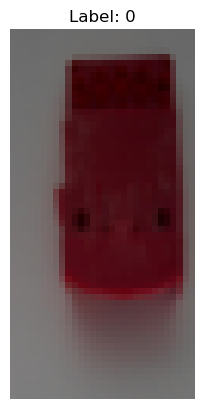

In [6]:
img_tensor, label = train_dataset[0]
transform_to_pil = T.ToPILImage()
img_pil = transform_to_pil(img_tensor)

plt.imshow(img_pil)
plt.title(f"Label: {label}")
plt.axis('off')
plt.show()

# Base model

In [7]:
class SimpleCNN(nn.Module):
    def __init__(self, input_channels, input_height, input_width, num_classes,
                 conv1_out_channels=16, conv2_out_channels=32, fc_neurons=128):
        super(SimpleCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(input_channels, conv1_out_channels, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Output: conv1_out_channels x H/2 x W/2
            nn.Conv2d(conv1_out_channels, conv2_out_channels, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)   # Output: conv2_out_channels x H/4 x W/4
        )
        
        # Calculate the flattened size dynamically
        with torch.no_grad():
            dummy_input = torch.zeros(1, input_channels, input_height, input_width)
            flattened_size = self.conv_layers(dummy_input).flatten(1).shape[1]
            
        self.fc_layers = nn.Sequential(
            nn.Linear(flattened_size, fc_neurons),
            nn.ReLU(),
            nn.Linear(fc_neurons, 1 if num_classes == 2 else num_classes) 
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.flatten(1) # Flatten all dimensions except batch
        x = self.fc_layers(x)
        return x

In [8]:
sample_img, _ = train_dataset[0]
C, H, W = sample_img.shape
print(f"Detected image shape: Channels={C}, Height={H}, Width={W}")

# Hyperparameters (Base Model)
learning_rate = 0.001
batch_size = 16 
num_epochs = 25 
num_classes = 2 

# Default architectural parameters for the base model
conv1_out_channels_base = 16
conv2_out_channels_base = 32
fc_neurons_base = 128

# Model, Loss, Optimizer
device = get_device()
print(f"Using device: {device}")

# DataLoaders
pin_memory_flag   = device.type == 'cuda'
num_workers_flag  = 2 if device.type == 'cuda' else 0   # 0 on M-series/CPU
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers_flag, pin_memory=pin_memory_flag)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers_flag, pin_memory=pin_memory_flag)

# Use the (potentially modified) SimpleCNN class
model = SimpleCNN(input_channels=C, input_height=H, input_width=W, num_classes=num_classes,
                    conv1_out_channels=conv1_out_channels_base, 
                    conv2_out_channels=conv2_out_channels_base, 
                    fc_neurons=fc_neurons_base).to(device)
# model = torch.compile(model)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
 
# Lists to store metrics for plotting
epoch_train_losses = []
epoch_test_accuracies = []
epoch_train_accuracies = [] # New list for training accuracies
 
# Training loop
for epoch in tqdm(range(num_epochs), desc="Training Progress", unit="epoch"):
    model.train()  
    running_loss = 0.0
    train_correct = 0 # To calculate training accuracy
    train_total = 0   # To calculate training accuracy
    for images, labels in train_loader:
        images = images.to(device)
        labels_float_unsqueezed = labels.to(device).float().unsqueeze(1)
 
        outputs = model(images)
        loss = criterion(outputs, labels_float_unsqueezed)
 
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
 
        running_loss += loss.item() * images.size(0) # loss.item() is avg loss for batch
       
        # For training accuracy
        # Get predictions on the training batch
        # No need for torch.no_grad() here as we are not backpropagating based on this
        predicted_train_batch = (torch.sigmoid(outputs) > 0.5).float()
        train_total += labels_float_unsqueezed.size(0)
        train_correct += (predicted_train_batch == labels_float_unsqueezed).sum().item()
   
    avg_epoch_loss = running_loss / len(train_loader.dataset)  # Average loss over the entire training set
    epoch_train_losses.append(avg_epoch_loss)
   
    # Calculate training accuracy for the epoch
    current_epoch_train_accuracy = 100 * train_correct / train_total if train_total > 0 else 0.0
    epoch_train_accuracies.append(current_epoch_train_accuracy)
   
    print(f"Epoch [{epoch+1}/{num_epochs}] completed. Average Training Loss: {avg_epoch_loss:.4f}, Training Accuracy: {current_epoch_train_accuracy:.2f}%")
 
    # Evaluation on the test set
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad(): 
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device).float().unsqueeze(1)
            
            outputs = model(images)
            predicted = (torch.sigmoid(outputs) > 0.5).float() 
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    epoch_test_accuracies.append(accuracy)
    print(f"Accuracy on test set after epoch {epoch+1}: {accuracy:.2f}%")

    if device.type == "mps":            # Apple-GPU path
        torch.mps.empty_cache()
    elif device.type == "cuda":         # NVIDIA-GPU path
        torch.cuda.empty_cache()
    gc.collect()                        # reclaim Python-held objects

print("Finished Training Base Model")

Detected image shape: Channels=3, Height=60, Width=30
Using device: mps


Training Progress:   0%|          | 0/25 [00:00<?, ?epoch/s]

Epoch [1/25] completed. Average Training Loss: 0.6960, Training Accuracy: 50.00%
Accuracy on test set after epoch 1: 50.00%
Epoch [2/25] completed. Average Training Loss: 0.6923, Training Accuracy: 52.21%
Accuracy on test set after epoch 2: 61.76%
Epoch [3/25] completed. Average Training Loss: 0.6872, Training Accuracy: 55.15%
Accuracy on test set after epoch 3: 70.59%
Epoch [4/25] completed. Average Training Loss: 0.6755, Training Accuracy: 72.79%
Accuracy on test set after epoch 4: 70.59%
Epoch [5/25] completed. Average Training Loss: 0.6539, Training Accuracy: 70.59%
Accuracy on test set after epoch 5: 70.59%
Epoch [6/25] completed. Average Training Loss: 0.6118, Training Accuracy: 77.94%
Accuracy on test set after epoch 6: 61.76%
Epoch [7/25] completed. Average Training Loss: 0.5584, Training Accuracy: 81.62%
Accuracy on test set after epoch 7: 73.53%
Epoch [8/25] completed. Average Training Loss: 0.5024, Training Accuracy: 78.68%
Accuracy on test set after epoch 8: 73.53%
Epoch [9

### Plots

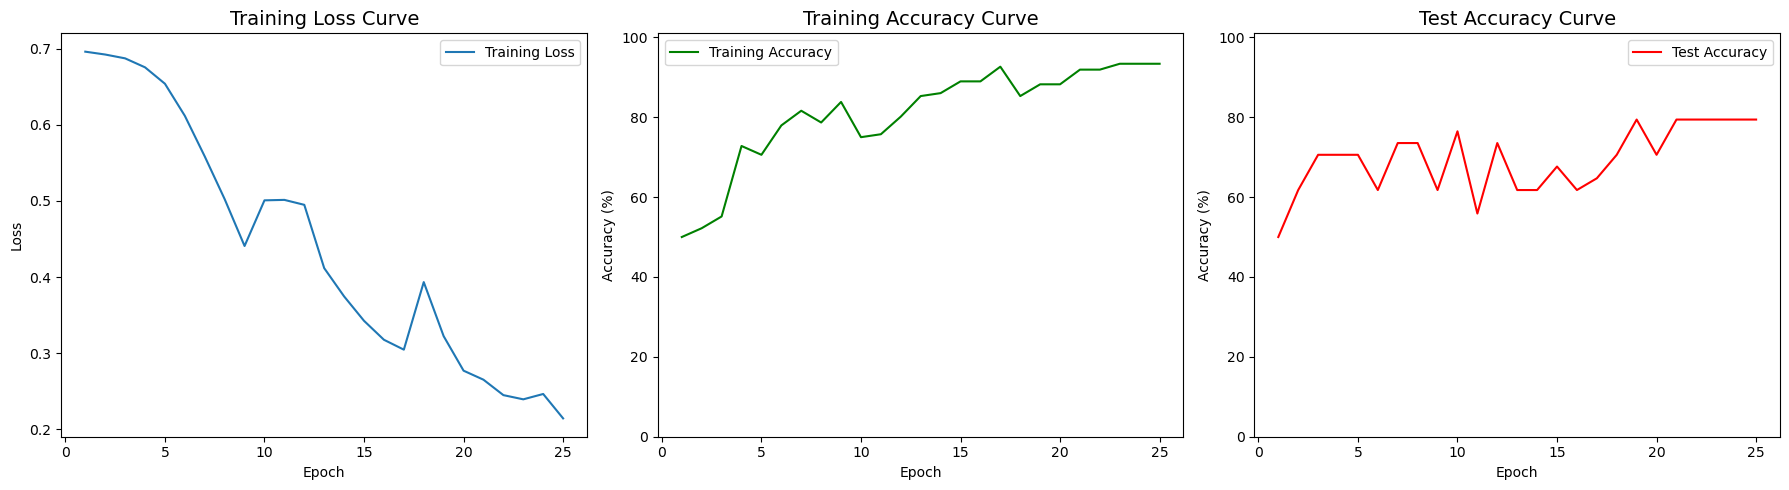

In [9]:
# Plotting learning curves
plt.figure(figsize=(18, 5)) # Adjusted figure size for three subplots
 
plt.subplot(1, 3, 1)
plt.plot(range(1, num_epochs + 1), epoch_train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve', fontsize=14)
plt.legend()
 
plt.subplot(1, 3, 2) # New subplot for Training Accuracy
plt.plot(range(1, num_epochs + 1), epoch_train_accuracies, label='Training Accuracy', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training Accuracy Curve', fontsize=14)
plt.legend()
plt.ylim(0, 101) # Optional: Set y-axis limits for accuracy
 
plt.subplot(1, 3, 3) # Adjusted subplot index for Test Accuracy
plt.plot(range(1, num_epochs + 1), epoch_test_accuracies, label='Test Accuracy', color='red')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy Curve', fontsize=14)
plt.legend()
plt.ylim(0, 101) # Optional: Set y-axis limits for accuracy
 
plt.tight_layout()
plt.show()
 

## Hyperparameter tuning

### Random Search

Using device for hyperparameter tuning: mps


Hyperparameter Search Trials:   0%|          | 0/10 [00:00<?, ?trial/s]


Trial 1/10 - Testing params: {'learning_rate': 0.01, 'batch_size': 32, 'conv1_out_channels': 16, 'conv2_out_channels': 32, 'fc_neurons': 128}


CV Folds:   0%|          | 0/5 [00:00<?, ?it/s]

  Fold 1/5


    Epochs (Fold 1):   0%|          | 0/19 [00:00<?, ?it/s]

  Fold 2/5


    Epochs (Fold 2):   0%|          | 0/19 [00:00<?, ?it/s]

  Fold 3/5


    Epochs (Fold 3):   0%|          | 0/19 [00:00<?, ?it/s]

  Fold 4/5


    Epochs (Fold 4):   0%|          | 0/19 [00:00<?, ?it/s]

  Fold 5/5


    Epochs (Fold 5):   0%|          | 0/19 [00:00<?, ?it/s]

  Trial 1 Avg CV Accuracy: 79.47%
  New best average CV accuracy: 79.47% with params: {'learning_rate': 0.01, 'batch_size': 32, 'conv1_out_channels': 16, 'conv2_out_channels': 32, 'fc_neurons': 128}

Trial 2/10 - Testing params: {'learning_rate': 0.001, 'batch_size': 16, 'conv1_out_channels': 8, 'conv2_out_channels': 64, 'fc_neurons': 256}


CV Folds:   0%|          | 0/5 [00:00<?, ?it/s]

  Fold 1/5


    Epochs (Fold 1):   0%|          | 0/19 [00:00<?, ?it/s]

  Fold 2/5


    Epochs (Fold 2):   0%|          | 0/19 [00:00<?, ?it/s]

  Fold 3/5


    Epochs (Fold 3):   0%|          | 0/19 [00:00<?, ?it/s]

  Fold 4/5


    Epochs (Fold 4):   0%|          | 0/19 [00:00<?, ?it/s]

  Fold 5/5


    Epochs (Fold 5):   0%|          | 0/19 [00:00<?, ?it/s]

  Trial 2 Avg CV Accuracy: 80.16%
  New best average CV accuracy: 80.16% with params: {'learning_rate': 0.001, 'batch_size': 16, 'conv1_out_channels': 8, 'conv2_out_channels': 64, 'fc_neurons': 256}

Trial 3/10 - Testing params: {'learning_rate': 0.005, 'batch_size': 16, 'conv1_out_channels': 8, 'conv2_out_channels': 64, 'fc_neurons': 64}


CV Folds:   0%|          | 0/5 [00:00<?, ?it/s]

  Fold 1/5


    Epochs (Fold 1):   0%|          | 0/19 [00:00<?, ?it/s]

  Fold 2/5


    Epochs (Fold 2):   0%|          | 0/19 [00:00<?, ?it/s]

  Fold 3/5


    Epochs (Fold 3):   0%|          | 0/19 [00:00<?, ?it/s]

  Fold 4/5


    Epochs (Fold 4):   0%|          | 0/19 [00:00<?, ?it/s]

  Fold 5/5


    Epochs (Fold 5):   0%|          | 0/19 [00:00<?, ?it/s]

  Trial 3 Avg CV Accuracy: 81.69%
  New best average CV accuracy: 81.69% with params: {'learning_rate': 0.005, 'batch_size': 16, 'conv1_out_channels': 8, 'conv2_out_channels': 64, 'fc_neurons': 64}

Trial 4/10 - Testing params: {'learning_rate': 0.01, 'batch_size': 32, 'conv1_out_channels': 32, 'conv2_out_channels': 64, 'fc_neurons': 256}


CV Folds:   0%|          | 0/5 [00:00<?, ?it/s]

  Fold 1/5


    Epochs (Fold 1):   0%|          | 0/19 [00:00<?, ?it/s]

  Fold 2/5


    Epochs (Fold 2):   0%|          | 0/19 [00:00<?, ?it/s]

  Fold 3/5


    Epochs (Fold 3):   0%|          | 0/19 [00:00<?, ?it/s]

  Fold 4/5


    Epochs (Fold 4):   0%|          | 0/19 [00:00<?, ?it/s]

  Fold 5/5


    Epochs (Fold 5):   0%|          | 0/19 [00:00<?, ?it/s]

  Trial 4 Avg CV Accuracy: 79.29%

Trial 5/10 - Testing params: {'learning_rate': 0.0005, 'batch_size': 16, 'conv1_out_channels': 32, 'conv2_out_channels': 64, 'fc_neurons': 256}


CV Folds:   0%|          | 0/5 [00:00<?, ?it/s]

  Fold 1/5


    Epochs (Fold 1):   0%|          | 0/19 [00:00<?, ?it/s]

  Fold 2/5


    Epochs (Fold 2):   0%|          | 0/19 [00:00<?, ?it/s]

  Fold 3/5


    Epochs (Fold 3):   0%|          | 0/19 [00:00<?, ?it/s]

  Fold 4/5


    Epochs (Fold 4):   0%|          | 0/19 [00:00<?, ?it/s]

  Fold 5/5


    Epochs (Fold 5):   0%|          | 0/19 [00:00<?, ?it/s]

  Trial 5 Avg CV Accuracy: 83.12%
  New best average CV accuracy: 83.12% with params: {'learning_rate': 0.0005, 'batch_size': 16, 'conv1_out_channels': 32, 'conv2_out_channels': 64, 'fc_neurons': 256}

Trial 6/10 - Testing params: {'learning_rate': 0.01, 'batch_size': 32, 'conv1_out_channels': 8, 'conv2_out_channels': 32, 'fc_neurons': 256}


CV Folds:   0%|          | 0/5 [00:00<?, ?it/s]

  Fold 1/5


    Epochs (Fold 1):   0%|          | 0/19 [00:00<?, ?it/s]

  Fold 2/5


    Epochs (Fold 2):   0%|          | 0/19 [00:00<?, ?it/s]

  Fold 3/5


    Epochs (Fold 3):   0%|          | 0/19 [00:00<?, ?it/s]

  Fold 4/5


    Epochs (Fold 4):   0%|          | 0/19 [00:00<?, ?it/s]

  Fold 5/5


    Epochs (Fold 5):   0%|          | 0/19 [00:00<?, ?it/s]

  Trial 6 Avg CV Accuracy: 76.01%

Trial 7/10 - Testing params: {'learning_rate': 0.001, 'batch_size': 8, 'conv1_out_channels': 8, 'conv2_out_channels': 32, 'fc_neurons': 256}


CV Folds:   0%|          | 0/5 [00:00<?, ?it/s]

  Fold 1/5


    Epochs (Fold 1):   0%|          | 0/19 [00:00<?, ?it/s]

  Fold 2/5


    Epochs (Fold 2):   0%|          | 0/19 [00:00<?, ?it/s]

  Fold 3/5


    Epochs (Fold 3):   0%|          | 0/19 [00:00<?, ?it/s]

  Fold 4/5


    Epochs (Fold 4):   0%|          | 0/19 [00:00<?, ?it/s]

  Fold 5/5


    Epochs (Fold 5):   0%|          | 0/19 [00:00<?, ?it/s]

  Trial 7 Avg CV Accuracy: 82.54%

Trial 8/10 - Testing params: {'learning_rate': 0.001, 'batch_size': 32, 'conv1_out_channels': 16, 'conv2_out_channels': 16, 'fc_neurons': 64}


CV Folds:   0%|          | 0/5 [00:00<?, ?it/s]

  Fold 1/5


    Epochs (Fold 1):   0%|          | 0/19 [00:00<?, ?it/s]

  Fold 2/5


    Epochs (Fold 2):   0%|          | 0/19 [00:00<?, ?it/s]

  Fold 3/5


    Epochs (Fold 3):   0%|          | 0/19 [00:00<?, ?it/s]

  Fold 4/5


    Epochs (Fold 4):   0%|          | 0/19 [00:00<?, ?it/s]

  Fold 5/5


    Epochs (Fold 5):   0%|          | 0/19 [00:00<?, ?it/s]

  Trial 8 Avg CV Accuracy: 80.21%

Trial 9/10 - Testing params: {'learning_rate': 0.005, 'batch_size': 8, 'conv1_out_channels': 8, 'conv2_out_channels': 64, 'fc_neurons': 64}


CV Folds:   0%|          | 0/5 [00:00<?, ?it/s]

  Fold 1/5


    Epochs (Fold 1):   0%|          | 0/19 [00:00<?, ?it/s]

  Fold 2/5


    Epochs (Fold 2):   0%|          | 0/19 [00:00<?, ?it/s]

  Fold 3/5


    Epochs (Fold 3):   0%|          | 0/19 [00:00<?, ?it/s]

  Fold 4/5


    Epochs (Fold 4):   0%|          | 0/19 [00:00<?, ?it/s]

  Fold 5/5


    Epochs (Fold 5):   0%|          | 0/19 [00:00<?, ?it/s]

  Trial 9 Avg CV Accuracy: 92.70%
  New best average CV accuracy: 92.70% with params: {'learning_rate': 0.005, 'batch_size': 8, 'conv1_out_channels': 8, 'conv2_out_channels': 64, 'fc_neurons': 64}

Trial 10/10 - Testing params: {'learning_rate': 0.001, 'batch_size': 16, 'conv1_out_channels': 16, 'conv2_out_channels': 16, 'fc_neurons': 256}


CV Folds:   0%|          | 0/5 [00:00<?, ?it/s]

  Fold 1/5


    Epochs (Fold 1):   0%|          | 0/19 [00:00<?, ?it/s]

  Fold 2/5


    Epochs (Fold 2):   0%|          | 0/19 [00:00<?, ?it/s]

  Fold 3/5


    Epochs (Fold 3):   0%|          | 0/19 [00:00<?, ?it/s]

  Fold 4/5


    Epochs (Fold 4):   0%|          | 0/19 [00:00<?, ?it/s]

  Fold 5/5


    Epochs (Fold 5):   0%|          | 0/19 [00:00<?, ?it/s]

  Trial 10 Avg CV Accuracy: 85.24%

Finished Hyperparameter Search.


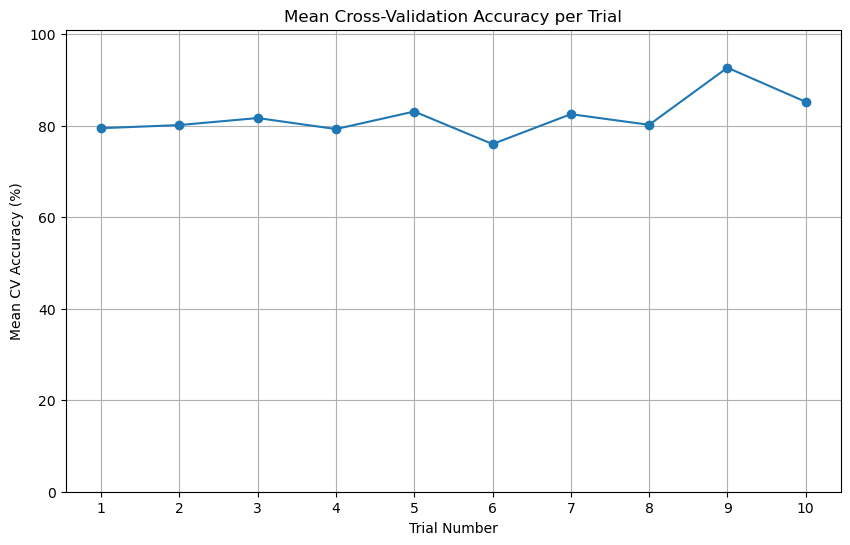

In [10]:
device = get_device()
print(f"Using device for hyperparameter tuning: {device}")
 
# Get image dimensions (C, H, W should be available from the previous cell or re-derived)
if 'C' not in locals() or 'H' not in locals() or 'W' not in locals():
    sample_img, _ = train_dataset[0]
    C, H, W = sample_img.shape
    print(f"Re-detected image shape: Channels={C}, Height={H}, Width={W}")
 
# Import KFold
from sklearn.model_selection import KFold
import numpy as np # Ensure numpy is imported
import matplotlib.pyplot as plt # Ensure matplotlib is imported for trial plots
 
# Hyperparameter search space
param_space = {
    'learning_rate': [0.0001, 0.0005, 0.001, 0.005, 0.01],
    'batch_size': [8, 16, 32],
    'conv1_out_channels': [8, 16, 32],
    'conv2_out_channels': [16, 32, 64],
    'fc_neurons': [64, 128, 256],
}
 
# Store history for the best model's learning curves
best_model_train_losses = []
best_model_val_accuracies = []
 
num_classes_hp = 2
num_epochs_search = 19 # Epochs for each fold in CV and for final retraining
num_trials = 10 # Number of random hyperparameter sets to try
n_splits_cv = 5 # Number of folds for cross-validation
 
best_hyperparams = None
best_avg_cv_accuracy = -1.0
# These will store learning curves for the FINAL retrained model
final_retrained_model_train_losses = []
final_retrained_model_test_accuracies = [] # Using test set for the final model's curve
 
perfect_found = False # If average CV accuracy hits 100%
 
all_trials_final_cv_accuracies = [] # To store final avg CV accuracy for each trial
 
for trial in tqdm(range(num_trials), desc="Hyperparameter Search Trials", unit="trial", leave=True):
    if perfect_found:
        print("Perfect hyperparameters found based on CV, stopping further trials.")
        break
 
    current_params = {k: random.choice(v) for k, v in param_space.items()}
    print(f"\nTrial {trial+1}/{num_trials} - Testing params: {current_params}")
 
    kf = KFold(n_splits=n_splits_cv, shuffle=True, random_state=trial)
   
    trial_fold_final_accuracies = []
    # Store epoch-wise validation accuracies for each fold, to average later for plotting
    # This is still useful if you want to debug or see per-fold performance, but not for the requested final plot
    trial_all_folds_epoch_val_accuracies = [[] for _ in range(num_epochs_search)]
 
    pin_memory_flag = device.type == 'cuda'
    num_workers_flag = 2 if device.type == 'cuda' else 0
 
    for fold_idx, (train_ids, val_ids) in enumerate(tqdm(kf.split(train_dataset), total=n_splits_cv, desc="CV Folds", leave=True)):        
    # for fold_idx, (train_ids, val_ids) in enumerate(kf.split(train_dataset)):
        print(f"  Fold {fold_idx+1}/{n_splits_cv}")
       
        train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
        val_subsampler = torch.utils.data.SubsetRandomSampler(val_ids)
 
        try:
            current_train_loader = DataLoader(train_dataset, batch_size=current_params['batch_size'], sampler=train_subsampler, num_workers=num_workers_flag, pin_memory=pin_memory_flag)
            current_val_loader = DataLoader(train_dataset, batch_size=current_params['batch_size'], sampler=val_subsampler, num_workers=num_workers_flag, pin_memory=pin_memory_flag)
        except Exception as e:
            print(f"  Error creating DataLoader for fold {fold_idx+1}, possibly due to batch size: {e}. Skipping fold.")
            trial_fold_final_accuracies.append(0)
            for epoch_list_idx in range(num_epochs_search):
                 if len(trial_all_folds_epoch_val_accuracies[epoch_list_idx]) == fold_idx :
                     trial_all_folds_epoch_val_accuracies[epoch_list_idx].append(0)
            continue
           
        model_hp = SimpleCNN(input_channels=C, input_height=H, input_width=W, num_classes=num_classes_hp,
                                conv1_out_channels=current_params['conv1_out_channels'],
                                conv2_out_channels=current_params['conv2_out_channels'],
                                fc_neurons=current_params['fc_neurons']).to(device)
       
        criterion_hp = nn.BCEWithLogitsLoss()
        optimizer_hp = optim.Adam(model_hp.parameters(), lr=current_params['learning_rate'])
 
        fold_epoch_val_accuracies = []
 
        for epoch in tqdm(range(num_epochs_search), desc=f"    Epochs (Fold {fold_idx+1})", leave=True):
            model_hp.train()
            # ... (training loop for the fold) ...
            epoch_running_loss = 0.0
            for images, labels in current_train_loader:
                images, labels = images.to(device), labels.to(device).float().unsqueeze(1)
                optimizer_hp.zero_grad()
                outputs = model_hp(images)
                loss = criterion_hp(outputs, labels)
                loss.backward()
                optimizer_hp.step()
                epoch_running_loss += loss.item() * images.size(0)
 
            model_hp.eval()
            val_correct = 0
            val_total = 0
            with torch.no_grad():
                for images, labels in current_val_loader:
                    images, labels = images.to(device), labels.to(device).float().unsqueeze(1)
                    outputs = model_hp(images)
                    predicted = (torch.sigmoid(outputs) > 0.5).float()
                    val_total += labels.size(0)
                    val_correct += (predicted == labels).sum().item()
           
            current_epoch_val_accuracy = 100 * val_correct / val_total if val_total > 0 else 0.0
            fold_epoch_val_accuracies.append(current_epoch_val_accuracy)
            trial_all_folds_epoch_val_accuracies[epoch].append(current_epoch_val_accuracy)
 
            if device.type == "mps": torch.mps.empty_cache()
            elif device.type == "cuda": torch.cuda.empty_cache()
            gc.collect()
       
        trial_fold_final_accuracies.append(fold_epoch_val_accuracies[-1] if fold_epoch_val_accuracies else 0.0)
        del model_hp, optimizer_hp, criterion_hp, current_train_loader, current_val_loader
        if device.type == "mps": torch.mps.empty_cache()
        elif device.type == "cuda": torch.cuda.empty_cache()
        gc.collect()
 
    current_trial_avg_final_cv_accuracy = np.mean(trial_fold_final_accuracies) if trial_fold_final_accuracies else 0.0
    all_trials_final_cv_accuracies.append(current_trial_avg_final_cv_accuracy) # Store for the final plot
    print(f"  Trial {trial+1} Avg CV Accuracy: {current_trial_avg_final_cv_accuracy:.2f}%")
 
    if current_trial_avg_final_cv_accuracy > best_avg_cv_accuracy:
        best_avg_cv_accuracy = current_trial_avg_final_cv_accuracy
        best_hyperparams = current_params
        print(f"  New best average CV accuracy: {best_avg_cv_accuracy:.2f}% with params: {best_hyperparams}")
 
    if best_avg_cv_accuracy == 100.0:
        perfect_found = True
       
print("\nFinished Hyperparameter Search.")
 
# Plot Mean CV Accuracy per Trial
if all_trials_final_cv_accuracies:
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(all_trials_final_cv_accuracies) + 1), all_trials_final_cv_accuracies, marker='o', linestyle='-')
    plt.title("Mean Cross-Validation Accuracy per Trial")
    plt.xlabel("Trial Number")
    plt.ylabel("Mean CV Accuracy (%)")
    plt.xticks(range(1, len(all_trials_final_cv_accuracies) + 1))
    plt.grid(True)
    plt.ylim(0, 101)
    plt.show()
 

In [11]:
best_model_train_losses = []
best_model_val_accuracies = []
best_model_train_accuracies = [] # New list for training accuracies
 
if best_hyperparams:
    print(f"Best hyperparameters found: {best_hyperparams}")
    print(f"Best average CV validation accuracy: {best_avg_cv_accuracy:.2f}%")
 
    # Retrain the model on the full training dataset with the best hyperparameters
    print("\nRetraining model with best hyperparameters on the full training dataset...")
   
    final_train_loader = DataLoader(train_dataset, batch_size=best_hyperparams['batch_size'], shuffle=True, num_workers=num_workers_flag, pin_memory=pin_memory_flag)
    final_test_loader = DataLoader(test_dataset, batch_size=best_hyperparams['batch_size'], shuffle=False, num_workers=num_workers_flag, pin_memory=pin_memory_flag)
 
    final_model = SimpleCNN(input_channels=C, input_height=H, input_width=W, num_classes=num_classes_hp,
                            conv1_out_channels=best_hyperparams['conv1_out_channels'],
                            conv2_out_channels=best_hyperparams['conv2_out_channels'],
                            fc_neurons=best_hyperparams['fc_neurons']).to(device)
   
    criterion_final = nn.BCEWithLogitsLoss()
    optimizer_final = optim.Adam(final_model.parameters(), lr=best_hyperparams['learning_rate'])
 
    best_model_train_losses.clear()
    best_model_val_accuracies.clear()
    best_model_train_accuracies.clear() # Clear training accuracies list
 
    for epoch in tqdm(range(num_epochs_search), desc="Final Model Retraining", unit="epoch"):
        final_model.train()
        running_loss = 0.0
        for images, labels in final_train_loader:
            images, labels = images.to(device), labels.to(device).float().unsqueeze(1)
            optimizer_final.zero_grad()
            outputs = final_model(images)
            loss = criterion_final(outputs, labels)
            loss.backward()
            optimizer_final.step()
            running_loss += loss.item() * images.size(0)
       
        avg_epoch_loss = running_loss / len(final_train_loader.dataset)
        best_model_train_losses.append(avg_epoch_loss)
 
        # Evaluate on the training set for training accuracy
        final_model.eval()
        train_correct = 0
        train_total = 0
        with torch.no_grad():
            for images_train, labels_train in final_train_loader:
                images_train, labels_train = images_train.to(device), labels_train.to(device).float().unsqueeze(1)
                outputs_train = final_model(images_train)
                predicted_train = (torch.sigmoid(outputs_train) > 0.5).float()
                train_total += labels_train.size(0)
                train_correct += (predicted_train == labels_train).sum().item()
        current_train_accuracy = 100 * train_correct / train_total if train_total > 0 else 0.0
        best_model_train_accuracies.append(current_train_accuracy)
 
        # Evaluate on the test set for test accuracy
        # final_model.eval() # Already in eval mode
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in final_test_loader:
                images, labels = images.to(device), labels.to(device).float().unsqueeze(1)
                outputs = final_model(images)
                predicted = (torch.sigmoid(outputs) > 0.5).float()
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
       
        accuracy = 100 * correct / total if total > 0 else 0.0
        best_model_val_accuracies.append(accuracy)
        print(f"  Epoch {epoch+1}/{num_epochs_search} - Train Loss: {avg_epoch_loss:.4f}, Train Acc: {current_train_accuracy:.2f}%, Test Acc: {accuracy:.2f}%")
 
        if device.type == "mps": torch.mps.empty_cache()
        elif device.type == "cuda": torch.cuda.empty_cache()
        gc.collect()
 
    best_randomsearch_model_path = "best_randomsearch_cnn_model.pth"
    torch.save(final_model.state_dict(), best_randomsearch_model_path)
    print(f"Best retrained model saved to {best_randomsearch_model_path}")
 
else:
    print("No best hyperparameters found (e.g., all trials failed or num_trials was 0).")
    best_model_train_losses = []
    best_model_val_accuracies = []
    best_model_train_accuracies = [] 
 

Best hyperparameters found: {'learning_rate': 0.005, 'batch_size': 8, 'conv1_out_channels': 8, 'conv2_out_channels': 64, 'fc_neurons': 64}
Best average CV validation accuracy: 92.70%

Retraining model with best hyperparameters on the full training dataset...


Final Model Retraining:   0%|          | 0/19 [00:00<?, ?epoch/s]

  Epoch 1/19 - Train Loss: 0.6948, Train Acc: 50.00%, Test Acc: 50.00%
  Epoch 2/19 - Train Loss: 0.6914, Train Acc: 50.00%, Test Acc: 50.00%
  Epoch 3/19 - Train Loss: 0.6859, Train Acc: 76.47%, Test Acc: 58.82%
  Epoch 4/19 - Train Loss: 0.6619, Train Acc: 74.26%, Test Acc: 55.88%
  Epoch 5/19 - Train Loss: 0.5393, Train Acc: 83.82%, Test Acc: 61.76%
  Epoch 6/19 - Train Loss: 0.4325, Train Acc: 77.94%, Test Acc: 73.53%
  Epoch 7/19 - Train Loss: 0.4749, Train Acc: 85.29%, Test Acc: 73.53%
  Epoch 8/19 - Train Loss: 0.4217, Train Acc: 72.79%, Test Acc: 58.82%
  Epoch 9/19 - Train Loss: 0.4897, Train Acc: 91.18%, Test Acc: 79.41%
  Epoch 10/19 - Train Loss: 0.3693, Train Acc: 89.71%, Test Acc: 73.53%
  Epoch 11/19 - Train Loss: 0.2713, Train Acc: 93.38%, Test Acc: 82.35%
  Epoch 12/19 - Train Loss: 0.2834, Train Acc: 94.85%, Test Acc: 88.24%
  Epoch 13/19 - Train Loss: 0.2225, Train Acc: 94.85%, Test Acc: 79.41%
  Epoch 14/19 - Train Loss: 0.2469, Train Acc: 94.12%, Test Acc: 85.29%
 

#### Plots

Best Average CV Accuracy (from Hyperparameter Search): 92.70%
Best Hyperparameters (from Hyperparameter Search): {'learning_rate': 0.005, 'batch_size': 8, 'conv1_out_channels': 8, 'conv2_out_channels': 64, 'fc_neurons': 64}
Final Retrained Model Train Accuracy: 97.06%
Final Retrained Model Test Accuracy: 88.24%
Number of epochs for retraining: 19


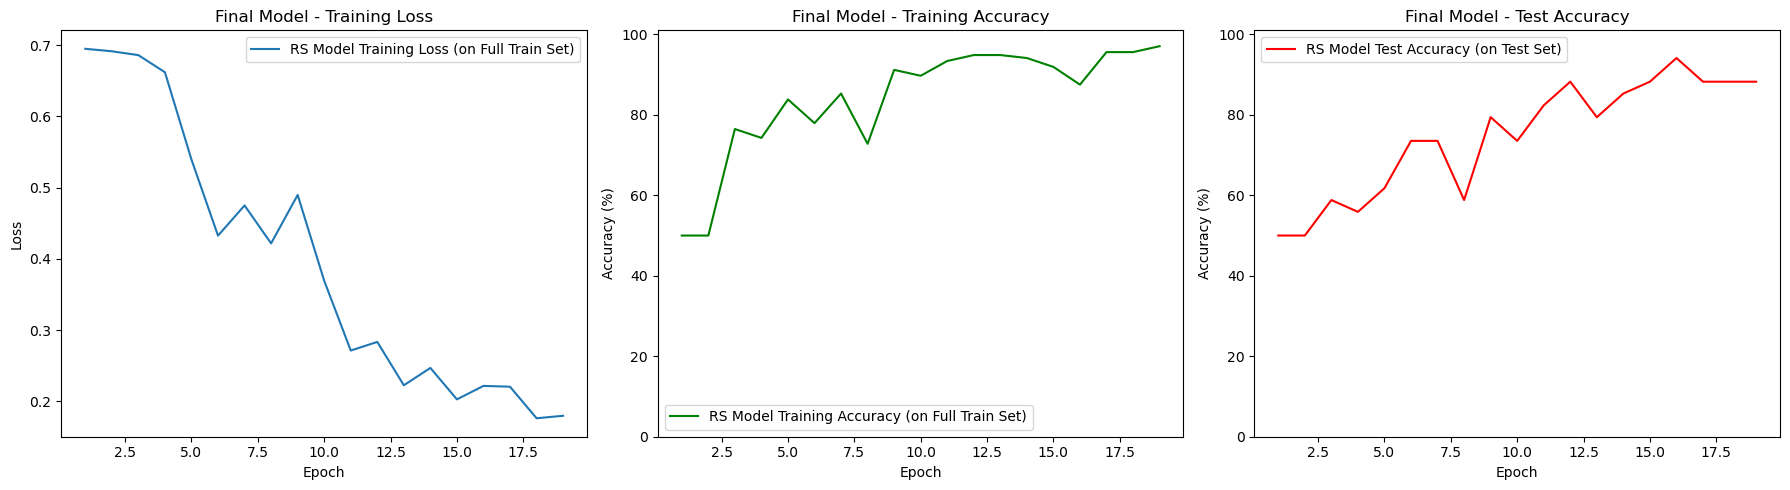

In [12]:
epochs = list(range(1, len(best_model_train_losses) + 1))
 
# best_avg_cv_accuracy is from the hyperparameter search phase
print(f"Best Average CV Accuracy (from Hyperparameter Search): {best_avg_cv_accuracy:.2f}%")
print(f"Best Hyperparameters (from Hyperparameter Search): {best_hyperparams}")
 
if epochs:
    # best_model_val_accuracies now contains test accuracies of the retrained model
    final_model_test_accuracy = best_model_val_accuracies[-1] # Get the last epoch's test accuracy
    if best_model_train_accuracies:
        final_model_train_accuracy = best_model_train_accuracies[-1]
        print(f"Final Retrained Model Train Accuracy: {final_model_train_accuracy:.2f}%")
    print(f"Final Retrained Model Test Accuracy: {final_model_test_accuracy:.2f}%")
    print(f"Number of epochs for retraining: {len(epochs)}")
else:
    print("No retraining was performed or data is missing for plotting.")
 
 
# Plotting learning curves for the best model from hyperparameter search
# These curves are from the model retrained on the full training set and evaluated on the test set.
if best_model_train_losses and best_model_val_accuracies and best_model_train_accuracies:
    plt.figure(figsize=(18, 5)) # Adjusted figure size for three subplots
 
    plt.subplot(1, 3, 1)
    plt.plot(epochs, best_model_train_losses, label='RS Model Training Loss (on Full Train Set)')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Final Model - Training Loss')
    plt.legend()
 
    plt.subplot(1, 3, 2) # New subplot for Training Accuracy
    plt.plot(epochs, best_model_train_accuracies, label='RS Model Training Accuracy (on Full Train Set)', color='green')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Final Model - Training Accuracy')
    plt.legend()
    plt.ylim(0, 101) # Optional: Set y-axis limits for accuracy
 
    plt.subplot(1, 3, 3) # Adjusted subplot index for Test Accuracy
    plt.plot(epochs, best_model_val_accuracies, label='RS Model Test Accuracy (on Test Set)', color='red')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Final Model - Test Accuracy')
    plt.legend()
    plt.ylim(0, 101) # Optional: Set y-axis limits for accuracy
 
    plt.tight_layout()
    plt.show()
else:
    print("Learning curve data for the final retrained model is not available or incomplete.")
 

### Method 2 - Optuna

In [13]:
# Device configuration
device = get_device()
print(f"Using device for Optuna hyperparameter tuning: {device}")
 
# Get image dimensions
sample_img, _ = train_dataset[0]
C, H, W = sample_img.shape
print(f"Image shape: Channels={C}, Height={H}, Width={W}")
 
num_classes_hp = 2
# num_epochs_search = 40 # This was for the old Optuna setup, now we define epochs per fold and for final retraining
num_trials_optuna = 10 # Define number of trials for Optuna
n_splits_cv_optuna = 5 # Number of folds for cross-validation within Optuna objective
num_epochs_cv_optuna = 19 # Number of epochs to train each fold during Optuna CV
 
def stop_when_perfect(study, trial):
    if trial.value is not None and trial.value >= 100.0: # Target 100% mean CV accuracy
        print(f"Trial {trial.number} achieved {trial.value} >= 100.0 mean CV accuracy. Stopping study.")
        study.stop()
 
def objective(trial):
    # Hyperparameter suggestions
    lr = trial.suggest_float("learning_rate", 1e-4, 1e-2, log=True)
    batch_size = trial.suggest_categorical("batch_size", [8, 16, 32])
    conv1_out = trial.suggest_categorical("conv1_out_channels", [8, 16, 32, 64])
    conv2_out = trial.suggest_categorical("conv2_out_channels", [16, 32, 64, 128])
    fc_neurons_val = trial.suggest_categorical("fc_neurons", [64, 128, 256])
 
    pin_memory_flag = device.type == 'cuda'
    num_workers_flag = 2 if device.type == 'cuda' else 0
 
    kf = KFold(n_splits=n_splits_cv_optuna, shuffle=True, random_state=trial.number)
    fold_final_val_accuracies = []
   
    patience_optuna_fold = 10 # Early stopping patience within each fold's training
 
    for fold_idx, (train_ids, val_ids) in enumerate(tqdm(kf.split(train_dataset), total=n_splits_cv_optuna, desc="CV Folds", leave=True)):        
        # print(f"  Trial {trial.number}, Fold {fold_idx+1}/{n_splits_cv_optuna}")
       
        train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
        val_subsampler = torch.utils.data.SubsetRandomSampler(val_ids)
 
        try:
            fold_train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_subsampler, num_workers=num_workers_flag, pin_memory=pin_memory_flag)
            fold_val_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=val_subsampler, num_workers=num_workers_flag, pin_memory=pin_memory_flag)
        except Exception as e:
            print(f"  Error creating DataLoader for Trial {trial.number}, Fold {fold_idx+1}: {e}. Pruning trial.")
            raise optuna.exceptions.TrialPruned() # Prune if DataLoader fails
 
        model_opt_fold = SimpleCNN(input_channels=C, input_height=H, input_width=W, num_classes=num_classes_hp,
                                   conv1_out_channels=conv1_out,
                                   conv2_out_channels=conv2_out,
                                   fc_neurons=fc_neurons_val).to(device)
       
        criterion_opt_fold = nn.BCEWithLogitsLoss()
        optimizer_opt_fold = optim.Adam(model_opt_fold.parameters(), lr=lr)
 
        fold_epoch_val_accuracies = []
        best_fold_val_acc = 0.0
        epochs_no_improve_fold = 0
 

        for epoch in tqdm(range(num_epochs_cv_optuna), desc=f"    Epochs (Trial {trial.number} Fold {fold_idx+1})", leave=True):
            model_opt_fold.train()
            # epoch_running_loss = 0.0 # Not strictly needed for objective's return value
            for images, labels in fold_train_loader:
                images, labels = images.to(device), labels.to(device).float().unsqueeze(1)
                optimizer_opt_fold.zero_grad(set_to_none=True)
                loss = criterion_opt_fold(model_opt_fold(images), labels)
                loss.backward()
                optimizer_opt_fold.step()
                # epoch_running_loss += loss.item() * images.size(0)
 
            model_opt_fold.eval()
            val_correct = 0
            val_total = 0
            with torch.no_grad():
                for images, labels in fold_val_loader:
                    images, labels = images.to(device), labels.to(device).float().unsqueeze(1)
                    outputs = model_opt_fold(images)
                    predicted = (torch.sigmoid(outputs) > 0.5).float()
                    val_total += labels.size(0)
                    val_correct += (predicted == labels).sum().item()
           
            current_fold_epoch_val_accuracy = 100 * val_correct / val_total if val_total > 0 else 0.0
            fold_epoch_val_accuracies.append(current_fold_epoch_val_accuracy)
 
            if current_fold_epoch_val_accuracy > best_fold_val_acc:
                best_fold_val_acc = current_fold_epoch_val_accuracy
                epochs_no_improve_fold = 0
            else:
                epochs_no_improve_fold += 1
           
            if epochs_no_improve_fold >= patience_optuna_fold:
                print(f"    Trial {trial.number} Fold {fold_idx+1}: Early stopping at epoch {epoch+1}.")
                break
       
        fold_final_val_accuracies.append(best_fold_val_acc if fold_epoch_val_accuracies else 0.0)
       
        # Report intermediate value (current fold's best accuracy) to Optuna for pruning
        trial.report(best_fold_val_acc, fold_idx)
        if trial.should_prune():
            print(f"    Trial {trial.number} Fold {fold_idx+1}: Pruned by Optuna.")
            del model_opt_fold, optimizer_opt_fold, criterion_opt_fold, fold_train_loader, fold_val_loader
            if device.type == "mps": torch.mps.empty_cache()
            elif device.type == "cuda": torch.cuda.empty_cache()
            gc.collect()
            raise optuna.exceptions.TrialPruned()
 
        del model_opt_fold, optimizer_opt_fold, criterion_opt_fold, fold_train_loader, fold_val_loader
        if device.type == "mps": torch.mps.empty_cache()
        elif device.type == "cuda": torch.cuda.empty_cache()
        gc.collect()
 
    mean_cv_accuracy = np.mean(fold_final_val_accuracies) if fold_final_val_accuracies else 0.0
    return mean_cv_accuracy
 
# Create a study object and optimize
study = optuna.create_study(direction="maximize",
                            pruner=optuna.pruners.MedianPruner(n_startup_trials=3, n_warmup_steps=1, interval_steps=1)) # Adjust pruner
study.optimize(objective, n_trials=num_trials_optuna, gc_after_trial=True, callbacks=[stop_when_perfect], show_progress_bar=True)
 
print("\nFinished Optuna Hyperparameter Search.")
if study.best_trial:
    best_trial_optuna = study.best_trial
    best_hyperparams_optuna = best_trial_optuna.params
    best_avg_cv_accuracy_optuna = best_trial_optuna.value # This is the mean CV accuracy
    print(f"Best trial number: {best_trial_optuna.number}")
    print(f"Best Mean CV Accuracy (from Optuna Search): {best_avg_cv_accuracy_optuna:.2f}%")
    print(f"Best Hyperparameters (from Optuna Search): {best_hyperparams_optuna}")
else:
    print("Optuna search did not yield a best trial (e.g., all trials pruned or failed).")
    best_hyperparams_optuna = None
    best_avg_cv_accuracy_optuna = -1.0
 
# These will be populated by the retraining step later
optuna_final_model_train_losses = []
optuna_final_model_train_accuracies = []
optuna_final_model_test_accuracies = []

Using device for Optuna hyperparameter tuning: mps


[I 2025-06-06 01:39:26,501] A new study created in memory with name: no-name-0d141cf9-0903-4062-9e4c-0c0f14d9c456


Image shape: Channels=3, Height=60, Width=30


  0%|          | 0/10 [00:00<?, ?it/s]

CV Folds:   0%|          | 0/5 [00:00<?, ?it/s]

    Epochs (Trial 0 Fold 1):   0%|          | 0/19 [00:00<?, ?it/s]

    Trial 0 Fold 1: Early stopping at epoch 11.


    Epochs (Trial 0 Fold 2):   0%|          | 0/19 [00:00<?, ?it/s]

    Trial 0 Fold 2: Early stopping at epoch 11.


    Epochs (Trial 0 Fold 3):   0%|          | 0/19 [00:00<?, ?it/s]

    Trial 0 Fold 3: Early stopping at epoch 11.


    Epochs (Trial 0 Fold 4):   0%|          | 0/19 [00:00<?, ?it/s]

    Epochs (Trial 0 Fold 5):   0%|          | 0/19 [00:00<?, ?it/s]

    Trial 0 Fold 5: Early stopping at epoch 19.
[I 2025-06-06 01:52:13,814] Trial 0 finished with value: 65.63492063492063 and parameters: {'learning_rate': 0.00011663996768639834, 'batch_size': 16, 'conv1_out_channels': 32, 'conv2_out_channels': 64, 'fc_neurons': 64}. Best is trial 0 with value: 65.63492063492063.


CV Folds:   0%|          | 0/5 [00:00<?, ?it/s]

    Epochs (Trial 1 Fold 1):   0%|          | 0/19 [00:00<?, ?it/s]

    Trial 1 Fold 1: Early stopping at epoch 16.


    Epochs (Trial 1 Fold 2):   0%|          | 0/19 [00:00<?, ?it/s]

    Epochs (Trial 1 Fold 3):   0%|          | 0/19 [00:00<?, ?it/s]

    Epochs (Trial 1 Fold 4):   0%|          | 0/19 [00:00<?, ?it/s]

    Trial 1 Fold 4: Early stopping at epoch 11.


    Epochs (Trial 1 Fold 5):   0%|          | 0/19 [00:00<?, ?it/s]

    Trial 1 Fold 5: Early stopping at epoch 11.
[I 2025-06-06 02:05:53,920] Trial 1 finished with value: 66.74603174603176 and parameters: {'learning_rate': 0.00011321393809739401, 'batch_size': 32, 'conv1_out_channels': 16, 'conv2_out_channels': 64, 'fc_neurons': 128}. Best is trial 1 with value: 66.74603174603176.


CV Folds:   0%|          | 0/5 [00:00<?, ?it/s]

    Epochs (Trial 2 Fold 1):   0%|          | 0/19 [00:00<?, ?it/s]

    Trial 2 Fold 1: Early stopping at epoch 18.


    Epochs (Trial 2 Fold 2):   0%|          | 0/19 [00:00<?, ?it/s]

    Epochs (Trial 2 Fold 3):   0%|          | 0/19 [00:00<?, ?it/s]

    Epochs (Trial 2 Fold 4):   0%|          | 0/19 [00:00<?, ?it/s]

    Epochs (Trial 2 Fold 5):   0%|          | 0/19 [00:00<?, ?it/s]

[I 2025-06-06 02:22:49,694] Trial 2 finished with value: 89.02116402116403 and parameters: {'learning_rate': 0.0009927330935426833, 'batch_size': 32, 'conv1_out_channels': 64, 'conv2_out_channels': 64, 'fc_neurons': 256}. Best is trial 2 with value: 89.02116402116403.


CV Folds:   0%|          | 0/5 [00:00<?, ?it/s]

    Epochs (Trial 3 Fold 1):   0%|          | 0/19 [00:00<?, ?it/s]

    Epochs (Trial 3 Fold 2):   0%|          | 0/19 [00:00<?, ?it/s]

    Trial 3 Fold 2: Early stopping at epoch 11.


    Epochs (Trial 3 Fold 3):   0%|          | 0/19 [00:00<?, ?it/s]

    Trial 3 Fold 3: Early stopping at epoch 11.


    Epochs (Trial 3 Fold 4):   0%|          | 0/19 [00:00<?, ?it/s]

    Epochs (Trial 3 Fold 5):   0%|          | 0/19 [00:00<?, ?it/s]

    Trial 3 Fold 5: Early stopping at epoch 17.
[I 2025-06-06 03:02:45,224] Trial 3 finished with value: 81.50793650793652 and parameters: {'learning_rate': 0.007186762821647583, 'batch_size': 8, 'conv1_out_channels': 32, 'conv2_out_channels': 64, 'fc_neurons': 64}. Best is trial 2 with value: 89.02116402116403.


CV Folds:   0%|          | 0/5 [00:00<?, ?it/s]

    Epochs (Trial 4 Fold 1):   0%|          | 0/19 [00:00<?, ?it/s]

    Epochs (Trial 4 Fold 2):   0%|          | 0/19 [00:00<?, ?it/s]

    Epochs (Trial 4 Fold 3):   0%|          | 0/19 [00:00<?, ?it/s]

    Epochs (Trial 4 Fold 4):   0%|          | 0/19 [00:00<?, ?it/s]

    Epochs (Trial 4 Fold 5):   0%|          | 0/19 [00:00<?, ?it/s]

[I 2025-06-06 03:19:25,906] Trial 4 finished with value: 94.10052910052909 and parameters: {'learning_rate': 0.001896548858862113, 'batch_size': 8, 'conv1_out_channels': 16, 'conv2_out_channels': 64, 'fc_neurons': 256}. Best is trial 4 with value: 94.10052910052909.


CV Folds:   0%|          | 0/5 [00:00<?, ?it/s]

    Epochs (Trial 5 Fold 1):   0%|          | 0/19 [00:00<?, ?it/s]

    Epochs (Trial 5 Fold 2):   0%|          | 0/19 [00:00<?, ?it/s]

    Epochs (Trial 5 Fold 3):   0%|          | 0/19 [00:00<?, ?it/s]

    Epochs (Trial 5 Fold 4):   0%|          | 0/19 [00:00<?, ?it/s]

    Epochs (Trial 5 Fold 5):   0%|          | 0/19 [00:00<?, ?it/s]

[I 2025-06-06 03:36:26,436] Trial 5 finished with value: 86.74603174603176 and parameters: {'learning_rate': 0.0011809028377759497, 'batch_size': 32, 'conv1_out_channels': 32, 'conv2_out_channels': 128, 'fc_neurons': 128}. Best is trial 4 with value: 94.10052910052909.


CV Folds:   0%|          | 0/5 [00:00<?, ?it/s]

    Epochs (Trial 6 Fold 1):   0%|          | 0/19 [00:00<?, ?it/s]

    Epochs (Trial 6 Fold 2):   0%|          | 0/19 [00:00<?, ?it/s]

    Epochs (Trial 6 Fold 3):   0%|          | 0/19 [00:00<?, ?it/s]

    Epochs (Trial 6 Fold 4):   0%|          | 0/19 [00:00<?, ?it/s]

    Epochs (Trial 6 Fold 5):   0%|          | 0/19 [00:00<?, ?it/s]

[I 2025-06-06 03:53:21,056] Trial 6 finished with value: 91.95767195767196 and parameters: {'learning_rate': 0.0012473321576449458, 'batch_size': 16, 'conv1_out_channels': 32, 'conv2_out_channels': 64, 'fc_neurons': 128}. Best is trial 4 with value: 94.10052910052909.


CV Folds:   0%|          | 0/5 [00:00<?, ?it/s]

    Epochs (Trial 7 Fold 1):   0%|          | 0/19 [00:00<?, ?it/s]

    Epochs (Trial 7 Fold 2):   0%|          | 0/19 [00:00<?, ?it/s]

    Epochs (Trial 7 Fold 3):   0%|          | 0/19 [00:00<?, ?it/s]

    Trial 7 Fold 3: Early stopping at epoch 16.


    Epochs (Trial 7 Fold 4):   0%|          | 0/19 [00:00<?, ?it/s]

    Epochs (Trial 7 Fold 5):   0%|          | 0/19 [00:00<?, ?it/s]

[I 2025-06-06 04:42:03,533] Trial 7 finished with value: 82.43386243386244 and parameters: {'learning_rate': 0.00012990782985710582, 'batch_size': 32, 'conv1_out_channels': 64, 'conv2_out_channels': 128, 'fc_neurons': 128}. Best is trial 4 with value: 94.10052910052909.


CV Folds:   0%|          | 0/5 [00:00<?, ?it/s]

    Epochs (Trial 8 Fold 1):   0%|          | 0/19 [00:00<?, ?it/s]

    Epochs (Trial 8 Fold 2):   0%|          | 0/19 [00:00<?, ?it/s]

    Epochs (Trial 8 Fold 3):   0%|          | 0/19 [00:00<?, ?it/s]

    Epochs (Trial 8 Fold 4):   0%|          | 0/19 [00:00<?, ?it/s]

    Trial 8 Fold 4: Early stopping at epoch 16.


    Epochs (Trial 8 Fold 5):   0%|          | 0/19 [00:00<?, ?it/s]

    Trial 8 Fold 5: Early stopping at epoch 15.
[I 2025-06-06 04:57:49,034] Trial 8 finished with value: 85.97883597883599 and parameters: {'learning_rate': 0.00013739329298172596, 'batch_size': 32, 'conv1_out_channels': 64, 'conv2_out_channels': 128, 'fc_neurons': 256}. Best is trial 4 with value: 94.10052910052909.


CV Folds:   0%|          | 0/5 [00:00<?, ?it/s]

    Epochs (Trial 9 Fold 1):   0%|          | 0/19 [00:00<?, ?it/s]

    Epochs (Trial 9 Fold 2):   0%|          | 0/19 [00:00<?, ?it/s]

    Trial 9 Fold 2: Early stopping at epoch 14.


    Epochs (Trial 9 Fold 3):   0%|          | 0/19 [00:00<?, ?it/s]

    Trial 9 Fold 3: Early stopping at epoch 11.


    Epochs (Trial 9 Fold 4):   0%|          | 0/19 [00:00<?, ?it/s]

    Epochs (Trial 9 Fold 5):   0%|          | 0/19 [00:00<?, ?it/s]

[I 2025-06-06 05:12:38,437] Trial 9 finished with value: 83.73015873015872 and parameters: {'learning_rate': 0.006238213268893065, 'batch_size': 16, 'conv1_out_channels': 32, 'conv2_out_channels': 128, 'fc_neurons': 256}. Best is trial 4 with value: 94.10052910052909.

Finished Optuna Hyperparameter Search.
Best trial number: 4
Best Mean CV Accuracy (from Optuna Search): 94.10%
Best Hyperparameters (from Optuna Search): {'learning_rate': 0.001896548858862113, 'batch_size': 8, 'conv1_out_channels': 16, 'conv2_out_channels': 64, 'fc_neurons': 256}


In [14]:
num_epochs_final_retrain_optuna = 25 # Define how many epochs for final retraining
 
optuna_final_model_train_losses = []
optuna_final_model_train_accuracies = []
optuna_final_model_test_accuracies = [] # Test accuracies for the retrained Optuna model
 
if best_hyperparams_optuna:
    print(f"\nRetraining best Optuna model with hyperparameters: {best_hyperparams_optuna}")
    print(f"Target Mean CV Accuracy was: {best_avg_cv_accuracy_optuna:.2f}%")
 
    pin_memory_flag = device.type == 'cuda'
    num_workers_flag = 2 if device.type == 'cuda' else 0
 
    # DataLoaders for final retraining (full train, full test)
    final_train_loader_optuna = DataLoader(train_dataset, batch_size=best_hyperparams_optuna['batch_size'], shuffle=True, num_workers=num_workers_flag, pin_memory=pin_memory_flag)
    final_test_loader_optuna = DataLoader(test_dataset, batch_size=best_hyperparams_optuna['batch_size'], shuffle=False, num_workers=num_workers_flag, pin_memory=pin_memory_flag)
 
    # Model instantiation
    final_model_optuna = SimpleCNN(input_channels=C, input_height=H, input_width=W, num_classes=num_classes_hp,
                                   conv1_out_channels=best_hyperparams_optuna['conv1_out_channels'],
                                   conv2_out_channels=best_hyperparams_optuna['conv2_out_channels'],
                                   fc_neurons=best_hyperparams_optuna['fc_neurons']).to(device)
   
    criterion_final_optuna = nn.BCEWithLogitsLoss()
    optimizer_final_optuna = optim.Adam(final_model_optuna.parameters(), lr=best_hyperparams_optuna['learning_rate'])
 
    for epoch in tqdm(range(num_epochs_final_retrain_optuna), desc="Optuna Final Model Retraining", unit="epoch"):
        final_model_optuna.train()
        running_loss = 0.0
        for images, labels in final_train_loader_optuna:
            images, labels = images.to(device), labels.to(device).float().unsqueeze(1)
            optimizer_final_optuna.zero_grad()
            outputs = final_model_optuna(images)
            loss = criterion_final_optuna(outputs, labels)
            loss.backward()
            optimizer_final_optuna.step()
            running_loss += loss.item() * images.size(0)
       
        avg_epoch_loss = running_loss / len(final_train_loader_optuna.dataset)
        optuna_final_model_train_losses.append(avg_epoch_loss)
 
        # Evaluate on the training set for training accuracy
        final_model_optuna.eval()
        train_correct = 0
        train_total = 0
        with torch.no_grad():
            for images_train, labels_train in final_train_loader_optuna: # Use the same train loader
                images_train, labels_train = images_train.to(device), labels_train.to(device).float().unsqueeze(1)
                outputs_train = final_model_optuna(images_train)
                predicted_train = (torch.sigmoid(outputs_train) > 0.5).float()
                train_total += labels_train.size(0)
                train_correct += (predicted_train == labels_train).sum().item()
        current_train_accuracy = 100 * train_correct / train_total if train_total > 0 else 0.0
        optuna_final_model_train_accuracies.append(current_train_accuracy)
 
        # Evaluate on the test set for test accuracy
        test_correct = 0
        test_total = 0
        with torch.no_grad():
            for images_test, labels_test in final_test_loader_optuna:
                images_test, labels_test = images_test.to(device), labels_test.to(device).float().unsqueeze(1)
                outputs_test = final_model_optuna(images_test)
                predicted_test = (torch.sigmoid(outputs_test) > 0.5).float()
                test_total += labels_test.size(0)
                test_correct += (predicted_test == labels_test).sum().item()
        current_test_accuracy = 100 * test_correct / test_total if test_total > 0 else 0.0
        optuna_final_model_test_accuracies.append(current_test_accuracy)
       
        print(f"  Epoch {epoch+1}/{num_epochs_final_retrain_optuna} - Train Loss: {avg_epoch_loss:.4f}, Train Acc: {current_train_accuracy:.2f}%, Test Acc: {current_test_accuracy:.2f}%")
 
        if device.type == "mps": torch.mps.empty_cache()
        elif device.type == "cuda": torch.cuda.empty_cache()
        gc.collect()
 
    best_optuna_retrained_model_path = "best_optuna_retrained_cnn_model.pth"
    torch.save(final_model_optuna.state_dict(), best_optuna_retrained_model_path)
    print(f"Best Optuna retrained model saved to {best_optuna_retrained_model_path}")
    if optuna_final_model_test_accuracies:
        print(f"Final Test Accuracy of retrained Optuna model: {optuna_final_model_test_accuracies[-1]:.2f}%")
 
else:
    print("No best hyperparameters found by Optuna to retrain.")
 


Retraining best Optuna model with hyperparameters: {'learning_rate': 0.001896548858862113, 'batch_size': 8, 'conv1_out_channels': 16, 'conv2_out_channels': 64, 'fc_neurons': 256}
Target Mean CV Accuracy was: 94.10%


Optuna Final Model Retraining:   0%|          | 0/25 [00:00<?, ?epoch/s]

  Epoch 1/25 - Train Loss: 0.7044, Train Acc: 50.00%, Test Acc: 50.00%
  Epoch 2/25 - Train Loss: 0.6836, Train Acc: 55.15%, Test Acc: 50.00%
  Epoch 3/25 - Train Loss: 0.6309, Train Acc: 80.15%, Test Acc: 64.71%
  Epoch 4/25 - Train Loss: 0.5734, Train Acc: 75.00%, Test Acc: 47.06%
  Epoch 5/25 - Train Loss: 0.5988, Train Acc: 69.12%, Test Acc: 73.53%
  Epoch 6/25 - Train Loss: 0.5518, Train Acc: 68.38%, Test Acc: 55.88%
  Epoch 7/25 - Train Loss: 0.5496, Train Acc: 76.47%, Test Acc: 47.06%
  Epoch 8/25 - Train Loss: 0.4731, Train Acc: 70.59%, Test Acc: 47.06%
  Epoch 9/25 - Train Loss: 0.4738, Train Acc: 78.68%, Test Acc: 73.53%
  Epoch 10/25 - Train Loss: 0.5221, Train Acc: 83.09%, Test Acc: 61.76%
  Epoch 11/25 - Train Loss: 0.4339, Train Acc: 80.88%, Test Acc: 64.71%
  Epoch 12/25 - Train Loss: 0.4051, Train Acc: 87.50%, Test Acc: 70.59%
  Epoch 13/25 - Train Loss: 0.3763, Train Acc: 91.18%, Test Acc: 76.47%
  Epoch 14/25 - Train Loss: 0.3559, Train Acc: 75.00%, Test Acc: 73.53%
 

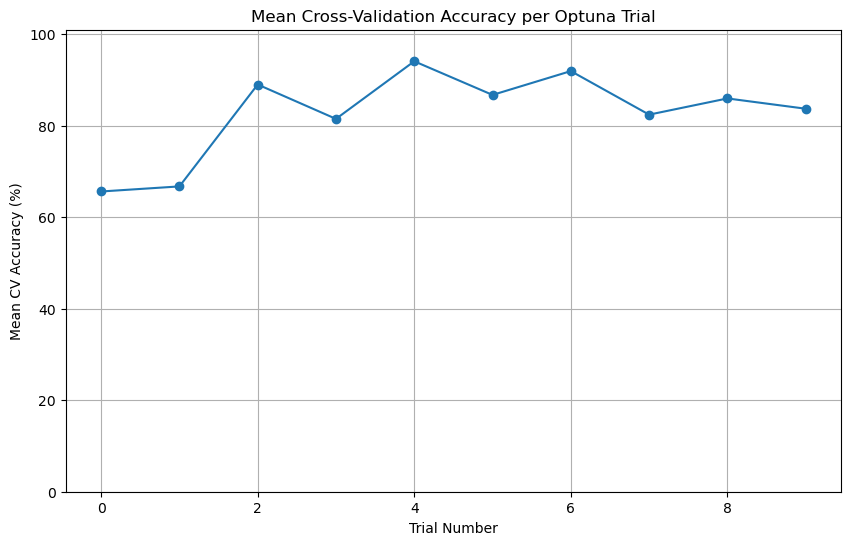


Plotting learning curves for the retrained Optuna model:
Best Hyperparameters (from Optuna Search): {'learning_rate': 0.001896548858862113, 'batch_size': 8, 'conv1_out_channels': 16, 'conv2_out_channels': 64, 'fc_neurons': 256}
Achieved Mean CV Accuracy during search: 94.10%
Final Test Accuracy of retrained model: 88.24%
Final Training Accuracy of retrained model: 94.85%
Number of epochs for final retraining: 25


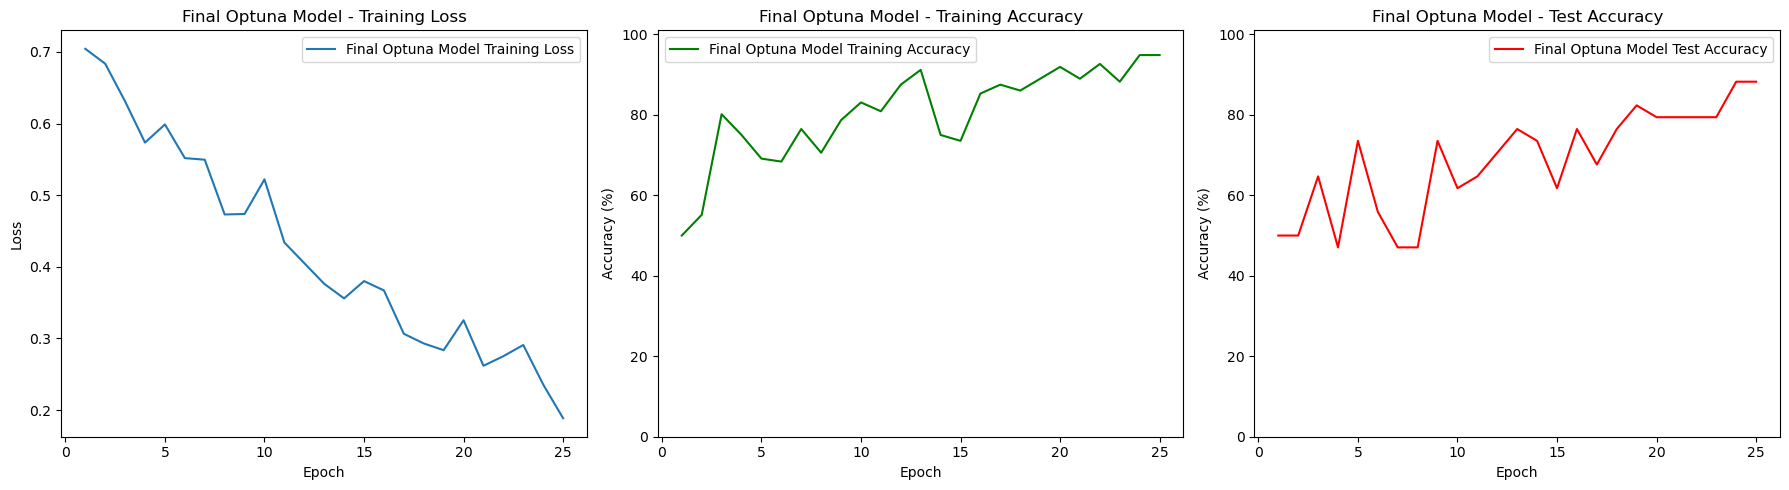

In [15]:
# Plot Mean CV Accuracy per Optuna Trial
if study and study.trials:
    completed_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE]
    if completed_trials:
        trial_numbers = [t.number for t in completed_trials]
        mean_cv_accuracies = [t.value for t in completed_trials] # t.value is the mean_cv_accuracy
 
        plt.figure(figsize=(10, 6))
        plt.plot(trial_numbers, mean_cv_accuracies, marker='o', linestyle='-')
        plt.title("Mean Cross-Validation Accuracy per Optuna Trial")
        plt.xlabel("Trial Number")
        plt.ylabel("Mean CV Accuracy (%)")
        # plt.xticks(trial_numbers) # Can be too crowded if many trials
        plt.grid(True)
        plt.ylim(min(0, np.min(mean_cv_accuracies)-5 if mean_cv_accuracies else 0), 101)
        plt.show()
    else:
        print("No completed Optuna trials to plot CV accuracy for.")
else:
    print("Optuna study object not available or no trials run.")
 
# Plotting learning curves for the FINAL RETRAINED best model from Optuna
print(f"\nPlotting learning curves for the retrained Optuna model:")
if best_hyperparams_optuna:
    print(f"Best Hyperparameters (from Optuna Search): {best_hyperparams_optuna}")
    print(f"Achieved Mean CV Accuracy during search: {best_avg_cv_accuracy_optuna:.2f}%")
    if optuna_final_model_test_accuracies:
         print(f"Final Test Accuracy of retrained model: {optuna_final_model_test_accuracies[-1]:.2f}%")
    if optuna_final_model_train_accuracies:
        print(f"Final Training Accuracy of retrained model: {optuna_final_model_train_accuracies[-1]:.2f}%")
    print(f"Number of epochs for final retraining: {num_epochs_final_retrain_optuna}")
else:
    print("No best Optuna model was retrained.")
 
optuna_epochs_retrain = list(range(1, len(optuna_final_model_train_losses) + 1))
 
if optuna_final_model_train_losses and optuna_final_model_train_accuracies and optuna_final_model_test_accuracies:
    plt.figure(figsize=(18, 5)) # Adjusted figure size for three subplots
 
    plt.subplot(1, 3, 1)
    plt.plot(optuna_epochs_retrain, optuna_final_model_train_losses, label='Final Optuna Model Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Final Optuna Model - Training Loss')
    plt.legend()
 
    plt.subplot(1, 3, 2)
    plt.plot(optuna_epochs_retrain, optuna_final_model_train_accuracies, label='Final Optuna Model Training Accuracy', color='green')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Final Optuna Model - Training Accuracy')
    plt.legend()
    plt.ylim(0, 101)
 
    plt.subplot(1, 3, 3)
    plt.plot(optuna_epochs_retrain, optuna_final_model_test_accuracies, label='Final Optuna Model Test Accuracy', color='red')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Final Optuna Model - Test Accuracy')
    plt.legend()
    plt.ylim(0, 101)
 
    plt.tight_layout()
    plt.show()
else:
    print("Learning curve data for the final retrained Optuna model is not available or incomplete.")
 

In [16]:
fig1 = plot_optimization_history(study)
fig1.show()  # in Jupyter this will render an interactive Plotly chart


In [17]:
fig2 = plot_param_importances(study)
fig2.show()


In [18]:
fig3 = plot_parallel_coordinate(study)
fig3.show()


In [19]:
fig4 = plot_slice(study, params=["learning_rate", "batch_size", "conv1_out_channels"])
fig4.show()

In [20]:
fig5 = plot_contour(study, params=["learning_rate", "batch_size"])
fig5.show()

In [25]:
num_epochs_search = 25

best_model_train_losses = []
best_model_val_accuracies = []
best_model_train_accuracies = [] # New list for training accuracies
 
if best_hyperparams:
    print(f"Best hyperparameters found: {best_hyperparams}")
    print(f"Best average CV validation accuracy: {best_avg_cv_accuracy:.2f}%")
 
    # Retrain the model on the full training dataset with the best hyperparameters
    print("\nRetraining model with best hyperparameters on the full training dataset...")
   
    try:
        del final_model
    except NameError:
        pass

    # (2) === CHANGED: Clear GPU/MPS cache before instantiating new model ===
    if device.type == "cuda":
        torch.cuda.empty_cache()
    elif device.type == "mps":
        torch.mps.empty_cache()
    gc.collect()
    
    final_train_loader = DataLoader(train_dataset, batch_size=best_hyperparams['batch_size'], shuffle=True, num_workers=num_workers_flag, pin_memory=pin_memory_flag)
    final_test_loader = DataLoader(test_dataset, batch_size=best_hyperparams['batch_size'], shuffle=False, num_workers=num_workers_flag, pin_memory=pin_memory_flag)
 
    final_model = SimpleCNN(input_channels=C, input_height=H, input_width=W, num_classes=num_classes_hp,
                            conv1_out_channels=best_hyperparams['conv1_out_channels'],
                            conv2_out_channels=best_hyperparams['conv2_out_channels'],
                            fc_neurons=best_hyperparams['fc_neurons']).to(device)
   
    criterion_final = nn.BCEWithLogitsLoss()
    optimizer_final = optim.Adam(final_model.parameters(), lr=best_hyperparams['learning_rate'])
 
    best_model_train_losses.clear()
    best_model_val_accuracies.clear()
    best_model_train_accuracies.clear() # Clear training accuracies list
 
    for epoch in tqdm(range(num_epochs_search), desc="Final Model Retraining", unit="epoch"):
        final_model.train()
        running_loss = 0.0
        for images, labels in final_train_loader:
            images, labels = images.to(device), labels.to(device).float().unsqueeze(1)
            optimizer_final.zero_grad()
            outputs = final_model(images)
            loss = criterion_final(outputs, labels)
            loss.backward()
            optimizer_final.step()
            running_loss += loss.item() * images.size(0)
       
        avg_epoch_loss = running_loss / len(final_train_loader.dataset)
        best_model_train_losses.append(avg_epoch_loss)
 
        # Evaluate on the training set for training accuracy
        final_model.eval()
        train_correct = 0
        train_total = 0
        with torch.no_grad():
            for images_train, labels_train in final_train_loader:
                images_train, labels_train = images_train.to(device), labels_train.to(device).float().unsqueeze(1)
                outputs_train = final_model(images_train)
                predicted_train = (torch.sigmoid(outputs_train) > 0.5).float()
                train_total += labels_train.size(0)
                train_correct += (predicted_train == labels_train).sum().item()
        current_train_accuracy = 100 * train_correct / train_total if train_total > 0 else 0.0
        best_model_train_accuracies.append(current_train_accuracy)
 
        # Evaluate on the test set for test accuracy
        # final_model.eval() # Already in eval mode
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in final_test_loader:
                images, labels = images.to(device), labels.to(device).float().unsqueeze(1)
                outputs = final_model(images)
                predicted = (torch.sigmoid(outputs) > 0.5).float()
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
       
        accuracy = 100 * correct / total if total > 0 else 0.0
        best_model_val_accuracies.append(accuracy)
        print(f"  Epoch {epoch+1}/{num_epochs_search} - Train Loss: {avg_epoch_loss:.4f}, Train Acc: {current_train_accuracy:.2f}%, Test Acc: {accuracy:.2f}%")
 
        if device.type == "mps": torch.mps.empty_cache()
        elif device.type == "cuda": torch.cuda.empty_cache()
        gc.collect()
 
    best_randomsearch_model_path = "best_randomsearch_cnn_model.pth"
    torch.save(final_model.state_dict(), best_randomsearch_model_path)
    print(f"Best retrained model saved to {best_randomsearch_model_path}")
 
else:
    print("No best hyperparameters found (e.g., all trials failed or num_trials was 0).")
    best_model_train_losses = []
    best_model_val_accuracies = []
    best_model_train_accuracies = [] 
 

Best hyperparameters found: {'learning_rate': 0.005, 'batch_size': 8, 'conv1_out_channels': 8, 'conv2_out_channels': 64, 'fc_neurons': 64}
Best average CV validation accuracy: 92.70%

Retraining model with best hyperparameters on the full training dataset...


Final Model Retraining:   0%|          | 0/25 [00:00<?, ?epoch/s]

  Epoch 1/25 - Train Loss: 0.7507, Train Acc: 50.00%, Test Acc: 50.00%
  Epoch 2/25 - Train Loss: 0.6956, Train Acc: 50.00%, Test Acc: 50.00%
  Epoch 3/25 - Train Loss: 0.6828, Train Acc: 75.00%, Test Acc: 76.47%
  Epoch 4/25 - Train Loss: 0.6147, Train Acc: 69.85%, Test Acc: 61.76%
  Epoch 5/25 - Train Loss: 0.5371, Train Acc: 82.35%, Test Acc: 61.76%
  Epoch 6/25 - Train Loss: 0.4641, Train Acc: 84.56%, Test Acc: 64.71%
  Epoch 7/25 - Train Loss: 0.4180, Train Acc: 79.41%, Test Acc: 76.47%
  Epoch 8/25 - Train Loss: 0.3906, Train Acc: 87.50%, Test Acc: 73.53%
  Epoch 9/25 - Train Loss: 0.4633, Train Acc: 77.21%, Test Acc: 70.59%
  Epoch 10/25 - Train Loss: 0.4390, Train Acc: 83.82%, Test Acc: 64.71%
  Epoch 11/25 - Train Loss: 0.3750, Train Acc: 77.94%, Test Acc: 73.53%
  Epoch 12/25 - Train Loss: 0.3642, Train Acc: 71.32%, Test Acc: 55.88%
  Epoch 13/25 - Train Loss: 0.4000, Train Acc: 77.94%, Test Acc: 73.53%
  Epoch 14/25 - Train Loss: 0.4197, Train Acc: 86.76%, Test Acc: 70.59%
 

Best Average CV Accuracy (from Hyperparameter Search): 92.70%
Best Hyperparameters (from Hyperparameter Search): {'learning_rate': 0.005, 'batch_size': 8, 'conv1_out_channels': 8, 'conv2_out_channels': 64, 'fc_neurons': 64}
Final Retrained Model Train Accuracy: 89.71%
Final Retrained Model Test Accuracy: 79.41%
Number of epochs for retraining: 25


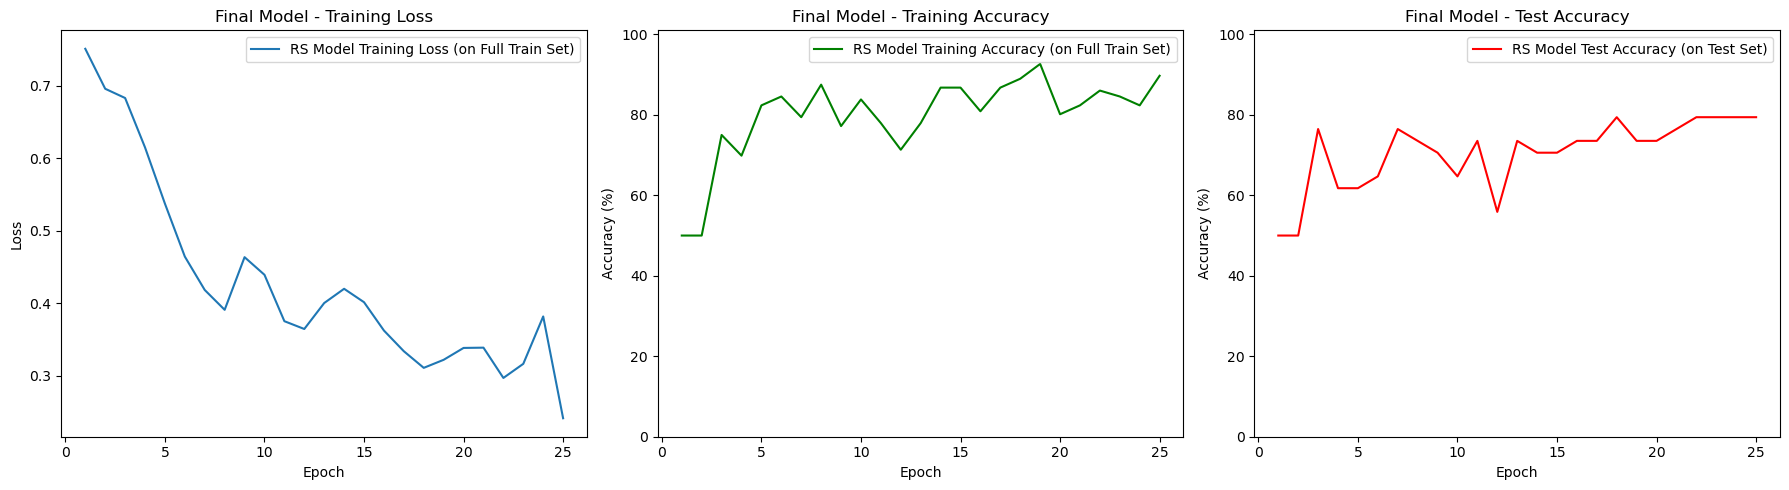

In [26]:
epochs = list(range(1, len(best_model_train_losses) + 1))
 
# best_avg_cv_accuracy is from the hyperparameter search phase
print(f"Best Average CV Accuracy (from Hyperparameter Search): {best_avg_cv_accuracy:.2f}%")
print(f"Best Hyperparameters (from Hyperparameter Search): {best_hyperparams}")
 
if epochs:
    # best_model_val_accuracies now contains test accuracies of the retrained model
    final_model_test_accuracy = best_model_val_accuracies[-1] # Get the last epoch's test accuracy
    if best_model_train_accuracies:
        final_model_train_accuracy = best_model_train_accuracies[-1]
        print(f"Final Retrained Model Train Accuracy: {final_model_train_accuracy:.2f}%")
    print(f"Final Retrained Model Test Accuracy: {final_model_test_accuracy:.2f}%")
    print(f"Number of epochs for retraining: {len(epochs)}")
else:
    print("No retraining was performed or data is missing for plotting.")
 
 
# Plotting learning curves for the best model from hyperparameter search
# These curves are from the model retrained on the full training set and evaluated on the test set.
if best_model_train_losses and best_model_val_accuracies and best_model_train_accuracies:
    plt.figure(figsize=(18, 5)) # Adjusted figure size for three subplots
 
    plt.subplot(1, 3, 1)
    plt.plot(epochs, best_model_train_losses, label='RS Model Training Loss (on Full Train Set)')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Final Model - Training Loss')
    plt.legend()
 
    plt.subplot(1, 3, 2) # New subplot for Training Accuracy
    plt.plot(epochs, best_model_train_accuracies, label='RS Model Training Accuracy (on Full Train Set)', color='green')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Final Model - Training Accuracy')
    plt.legend()
    plt.ylim(0, 101) # Optional: Set y-axis limits for accuracy
 
    plt.subplot(1, 3, 3) # Adjusted subplot index for Test Accuracy
    plt.plot(epochs, best_model_val_accuracies, label='RS Model Test Accuracy (on Test Set)', color='red')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Final Model - Test Accuracy')
    plt.legend()
    plt.ylim(0, 101) # Optional: Set y-axis limits for accuracy
 
    plt.tight_layout()
    plt.show()
else:
    print("Learning curve data for the final retrained model is not available or incomplete.")
 